In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import fireworks.ic as fic
import fireworks.nbodylib.integrators as fint
import fireworks.nbodylib.dynamics as fdyn
import fireworks.nbodylib.timesteps as ftim




In [10]:
#Simulation for trajectory
def simulate_trajectory(integrator, planets, dt, dynamics):
    position = []
    velocity = []
    time = []
    acceleration = []
    potential = []
    total_energy = []
    error = []
    t = 0.

    velocity.append(planets.vel.copy())
    position.append(planets.pos.copy())
    initial_acc = dynamics(planets)
    acceleration.append(initial_acc[0].copy() if initial_acc is not None else np.zeros_like(planets.pos[0]))
    total_energy.append(planets.Etot()[0])
    error.append(np.zeros_like(planets.Etot()[0]))
    time.append(t)

    Tperiod = np.sqrt(np.sum(planets.mass) / np.linalg.norm(planets.pos[0] - planets.pos[1]) ** 3)
    

    while t < 1000*Tperiod:
        t += dt
        planets, _, acc, _, pot = integrator(particles=planets, tstep=dt, acceleration_estimator=dynamics)
        Etot = planets.Etot()[0]
        Error = (Etot - total_energy[-1])/total_energy[-1]
        position.append(planets.pos.copy())
        velocity.append(planets.vel.copy())
        acceleration.append(acc.copy() if acc is not None else np.zeros_like(planets.pos[0]))
        potential.append(pot)
        total_energy.append(Etot)
        error.append(Error)

        time.append(t)

    position = np.array(position)
    velocity = np.array(velocity)
    acceleration = np.array(acceleration, dtype=object)
    potential = np.array(potential)
    time = np.array(time)
    total_energy = np.array(total_energy)
    error = np.array(error)

    return position, velocity, acceleration, potential, time, total_energy, error


In [11]:
def simulate_trajectory_tsunami(integrator, planets, adaptive_dt):
    position = []
    velocity = []
    time = []
    acceleration = []
    potential = []
    total_energy = []
    error = []
    t = 0.

    velocity.append(planets.vel.copy())
    position.append(planets.pos.copy())
    initial_acc = None
    acceleration.append(initial_acc[0].copy() if initial_acc is not None else np.zeros_like(planets.pos[0]))
    total_energy.append(planets.Etot()[0])
    error.append(np.zeros_like(planets.Etot()[0]))
    time.append(t)

    Tperiod = np.sqrt(np.sum(planets.mass) / np.linalg.norm(planets.pos[0] - planets.pos[1]) ** 3)

    while t < 1000*Tperiod:
        planets, efftime,_,_,pot=integrator(planets,dt)
        t += efftime
        #print("Value of dt evolved:\t" + str(efftime))
        
        Etot = planets.Etot()[0]
        Error = (Etot - total_energy[-1])/total_energy[-1]
        position.append(planets.pos.copy())
        velocity.append(planets.vel.copy())
        acceleration.append(planets.acc.copy() if planets.acc is not None else np.zeros_like(planets.pos[0]))
        potential.append(pot)
        total_energy.append(Etot)
        error.append(Error)

        time.append(t)

    position = np.array(position)
    velocity = np.array(velocity)
    acceleration = np.array(acceleration, dtype=object)
    potential = np.array(potential)
    time = np.array(time)
    total_energy = np.array(total_energy)
    error = np.array(error)

    return position, velocity, acceleration, potential, time, total_energy, error


In [12]:
# Defining plot
def plot_trajectory(position, ax, label):
    x_particle1, y_particle1, z_particle1 = position[:, 0, 0], position[:, 0, 1], position[:, 0, 2]
    x_particle2, y_particle2, z_particle2 = position[:, 1, 0], position[:, 1, 1], position[:, 1, 2]

    ax.plot(x_particle1, y_particle1, z_particle1, marker=',', label=f'Particle 1 - {label}')
    ax.plot(x_particle2, y_particle2, z_particle2, marker=',', label=f'Particle 2 - {label}')

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.legend(fontsize='small')

def plot_energy(total_energy, ax, label):
    ax.plot(t, total_energy, marker=',', label=f'Particle 1 - {label}')

    ax.set_xlabel('Time')
    ax.set_ylabel('Total Energy')

    ax.legend(fontsize='small')

def plot_energy_loss(error, ax, label):
    ax.plot(t, error, marker=',', label=f'Particle 1 - {label}')

    ax.set_xlabel('Time')
    ax.set_ylabel('Energy Error')

    ax.legend(fontsize='small')
def plot_2d_trajectory(position,ax,label):
    num_particles = position.shape[1]  # Assuming position has shape (time_steps, num_particles, 3)
    
    for particle_index in range(num_particles):
        x_particle, y_particle = position[:, particle_index, 0], position[:, particle_index, 1]
        ax.plot(x_particle, y_particle, marker=',', label=f'Particle {particle_index + 1} - {label}')
    
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    
    
    ax.legend(fontsize='small')


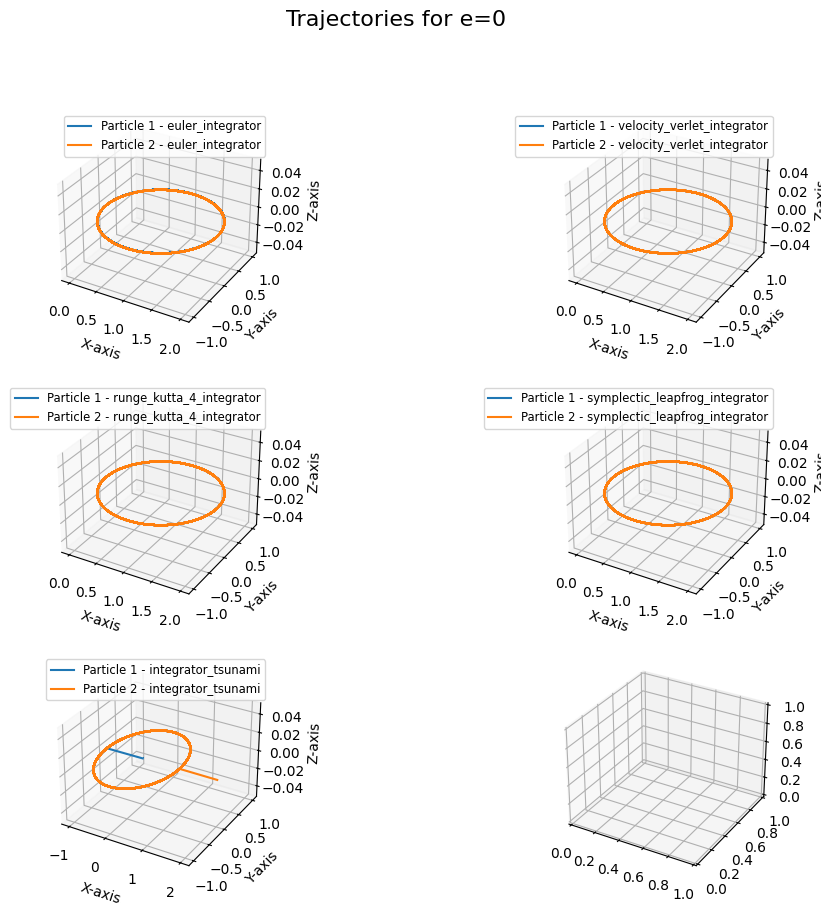

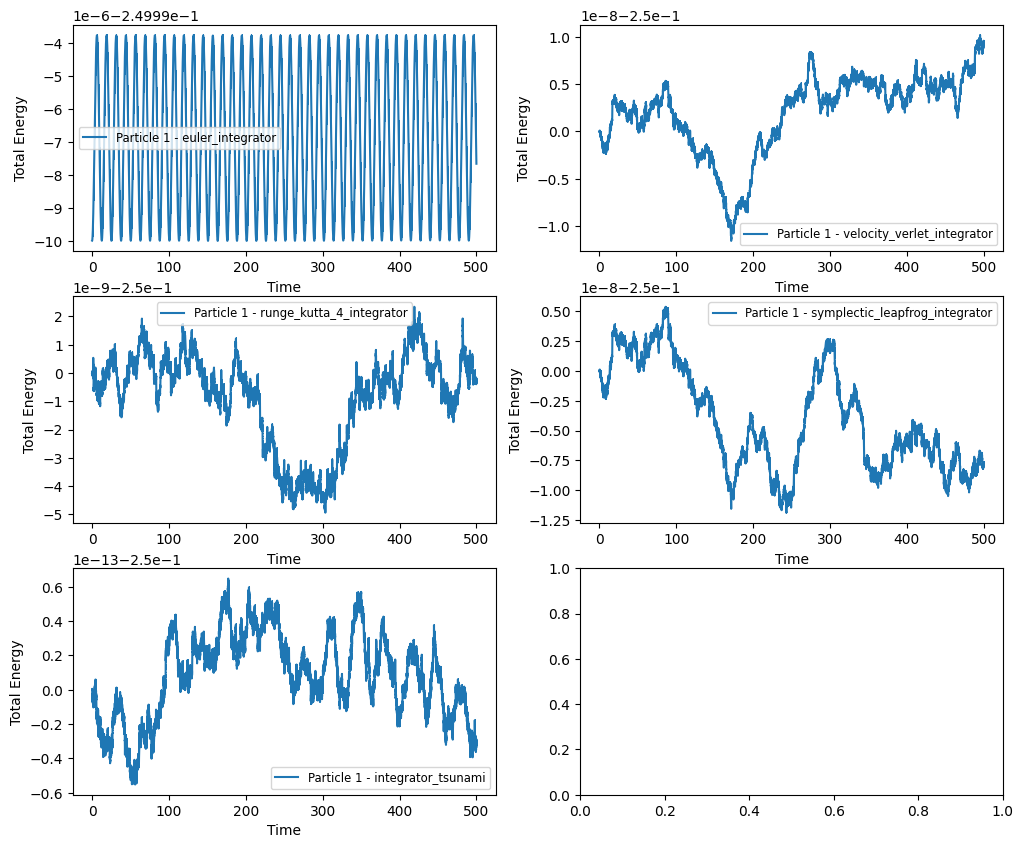

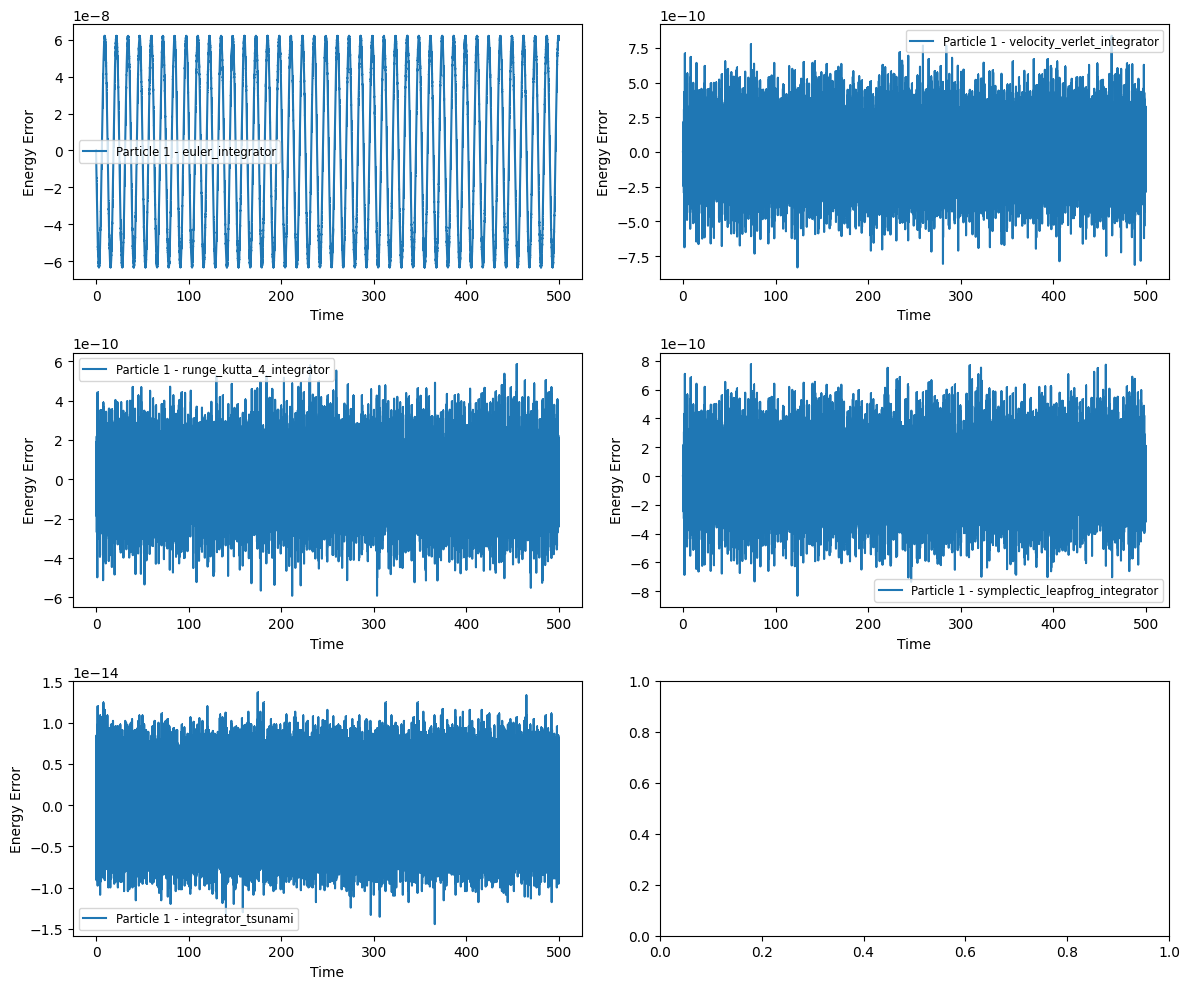

In [13]:
############################# Main C #####################################
dt = 0.01
# Different eccentricities
eccentricities = [0]#,0.5, 0.9, 0.99]
# Different integrators
integrators = [fint.euler_integrator, fint.velocity_verlet_integrator,
               fint.runge_kutta_4_integrator, fint.symplectic_leapfrog_integrator, fint.integrator_tsunami]
# Creating subplots
for e in eccentricities:
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), subplot_kw={'projection': '3d'})
    axes = axes.flatten()
    
    fig_tot_energy, axes_tot_energy = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
    axes_tot_energy = axes_tot_energy.flatten()
    
    fig_error,axes_loss = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
    axes_loss = axes_loss.flatten()

    planets = fic.ic_two_body(mass1=1., mass2=1., rp=2., e=e)
    
    for integrator, ax, ax_en,ax_loss in zip(integrators, axes, axes_tot_energy,axes_loss):
        if(integrator.__name__=="integrator_tsunami"):
            position, _, _, _, t, tot_en,error = simulate_trajectory_tsunami(fint.integrator_tsunami, planets.copy(), dt)
            plot_trajectory(position, ax, f'{integrator.__name__}')
            plot_energy(tot_en,ax_en, f'{integrator.__name__}')
            plot_energy_loss(error,ax_loss,f'{integrator.__name__}')
        else:
            position, _, acc, _, t, tot_en,error = simulate_trajectory(integrator, planets.copy(), dt, fdyn.acceleration_pyfalcon)
            plot_trajectory(position, ax, f'{integrator.__name__}')
            plot_energy(tot_en,ax_en, f'{integrator.__name__}')
            plot_energy_loss(error,ax_loss,f'{integrator.__name__}')

    fig.suptitle(f'Trajectories for e={e}', fontsize=16)
    plt.tight_layout()
    plt.show()
    # fig.savefig(f"Trajectories_e_{e}.png")
    # fig_tot_energy.savefig(f"TotalEnergy_e_{e}.png")
    # fig_error.savefig(f"Energy_loss_e_{e}.png")
    

## Adaptive Timestep task D

In [17]:
#Simulation for trajectory
def simulate_trajectory(integrator, planets, adaptive_dt, dynamics):
    position = []
    velocity = []
    time = []
    acceleration = []
    potential = []
    total_energy = []
    error = []
    t = 0.

    velocity.append(planets.vel.copy())
    position.append(planets.pos.copy())
    initial_acc = dynamics(planets)
    acceleration.append(initial_acc[0].copy() if initial_acc is not None else np.zeros_like(planets.pos[0]))
    total_energy.append(planets.Etot()[0])
    error.append(np.zeros_like(planets.Etot()[0]))
    time.append(t)

    Tperiod = np.sqrt(np.sum(planets.mass) / np.linalg.norm(planets.pos[0] - planets.pos[1]) ** 3)
    """ i=0

    print("Value of e:\t" + str(e))
    print(adaptive_dt.__name__)
    print(integrator.__name__)
    print(dynamics.__name__)
    print("Acceleration:\t" + str(planets.acc))
    print("Velocity module:\t" + str(planets.vel_mod()))
    print(velocity) """

    while t < 1000*Tperiod:
        """ print("####################################################")
        print(i)
        i+=1
        print("Value of e:\t" + str(e))
        print(adaptive_dt.__name__)
        print(integrator.__name__)
        print(dynamics.__name__)
        print("Acceleration:\t" + str(planets.acc))
        print("Velocity module:\t" + str(planets.vel_mod()))
        if planets.acc is None:
            print("inside program: None")
        else:
            print("inside program: Not None")
            print("Squared module of the acceleration:\t" + str(planets.acc_mod()))
            print("Norm of Acceleration:\t" + str(np.linalg.norm(planets.acc,axis=1)))
            print("Values of dt calculated:\t" + str(planets.vel_mod()/np.linalg.norm(planets.acc,axis=1)))
            print("Value of dt supposed to be chosen:\t" + str(np.nanmin(planets.vel_mod()/np.linalg.norm(planets.acc,axis=1)))) """
        tmin=0.001
        dt = adaptive_dt(planets,tmin=tmin)
        #print("Value of dt chosen:\t" + str(dt))
        t += dt
        planets, _, acc, _, pot = integrator(particles=planets, tstep=dt, acceleration_estimator=dynamics)
        Etot = planets.Etot()[0]
        Error = (Etot - total_energy[-1])/total_energy[-1]
        position.append(planets.pos.copy())
        velocity.append(planets.vel.copy())
        acceleration.append(acc.copy() if acc is not None else np.zeros_like(planets.pos[0]))
        potential.append(pot)
        total_energy.append(Etot)
        error.append(Error)

        time.append(t)

    position = np.array(position)
    velocity = np.array(velocity)
    acceleration = np.array(acceleration, dtype=object)
    potential = np.array(potential)
    time = np.array(time)
    total_energy = np.array(total_energy)
    error = np.array(error)

    return position, velocity, acceleration, potential, time, total_energy, error

def simulate_trajectory_tsunami(integrator, planets, adaptive_dt):
    position = []
    velocity = []
    time = []
    acceleration = []
    potential = []
    total_energy = []
    error = []
    t = 0.

    velocity.append(planets.vel.copy())
    position.append(planets.pos.copy())
    initial_acc = None
    acceleration.append(initial_acc[0].copy() if initial_acc is not None else np.zeros_like(planets.pos[0]))
    total_energy.append(planets.Etot()[0])
    error.append(np.zeros_like(planets.Etot()[0]))
    time.append(t)

    Tperiod = np.sqrt(np.sum(planets.mass) / np.linalg.norm(planets.pos[0] - planets.pos[1]) ** 3)
    """ i=0

    print("Value of e:\t" + str(e))
    print(adaptive_dt.__name__)
    print(integrator.__name__)
    print("Acceleration:\t" + str(planets.acc))
    print("Velocity module:\t" + str(planets.vel_mod()))
    print(velocity) """

    while t < 1000*Tperiod:
        """ print("####################################################")
        print(i)
        i+=1
        print("Value of e:\t" + str(e))
        print(adaptive_dt.__name__)
        print(integrator.__name__)
        print(dynamics.__name__)
        print("Acceleration:\t" + str(planets.acc))
        print("Velocity module:\t" + str(planets.vel_mod()))
        if planets.acc is None:
            print("inside program: None")
        else:
            print("inside program: Not None")
            print("Squared module of the acceleration:\t" + str(planets.acc_mod()))
            print("Norm of Acceleration:\t" + str(np.linalg.norm(planets.acc,axis=1)))
            print("Values of dt calculated:\t" + str(planets.vel_mod()/np.linalg.norm(planets.acc,axis=1)))
            print("Value of dt supposed to be chosen:\t" + str(np.nanmin(planets.vel_mod()/np.linalg.norm(planets.acc,axis=1)))) """
        tmin=0.001
        dt = adaptive_dt(planets,tmin=tmin)
        planets, efftime,_,_,pot=integrator(planets,dt)
        t += efftime
        #print("Value of dt evolved:\t" + str(efftime))
        
        Etot = planets.Etot()[0]
        Error = (Etot - total_energy[-1])/total_energy[-1]
        position.append(planets.pos.copy())
        velocity.append(planets.vel.copy())
        acceleration.append(planets.acc.copy() if planets.acc is not None else np.zeros_like(planets.pos[0]))
        potential.append(pot)
        total_energy.append(Etot)
        error.append(Error)

        time.append(t)

    position = np.array(position)
    velocity = np.array(velocity)
    acceleration = np.array(acceleration, dtype=object)
    potential = np.array(potential)
    time = np.array(time)
    total_energy = np.array(total_energy)
    error = np.array(error)

    return position, velocity, acceleration, potential, time, total_energy, error

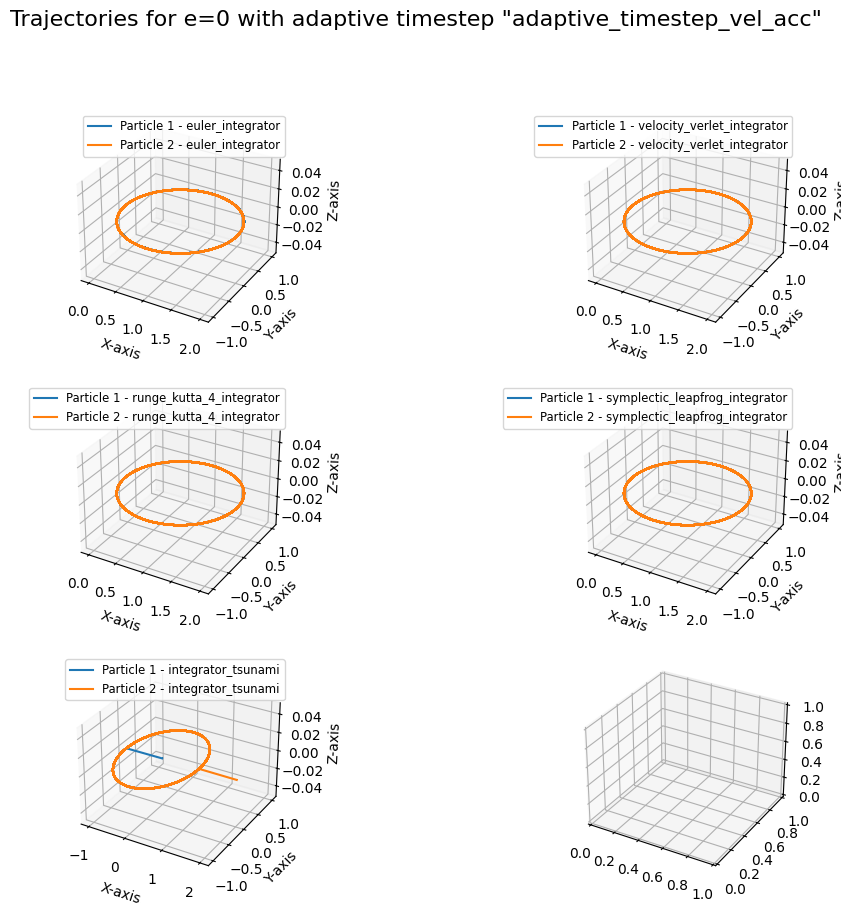

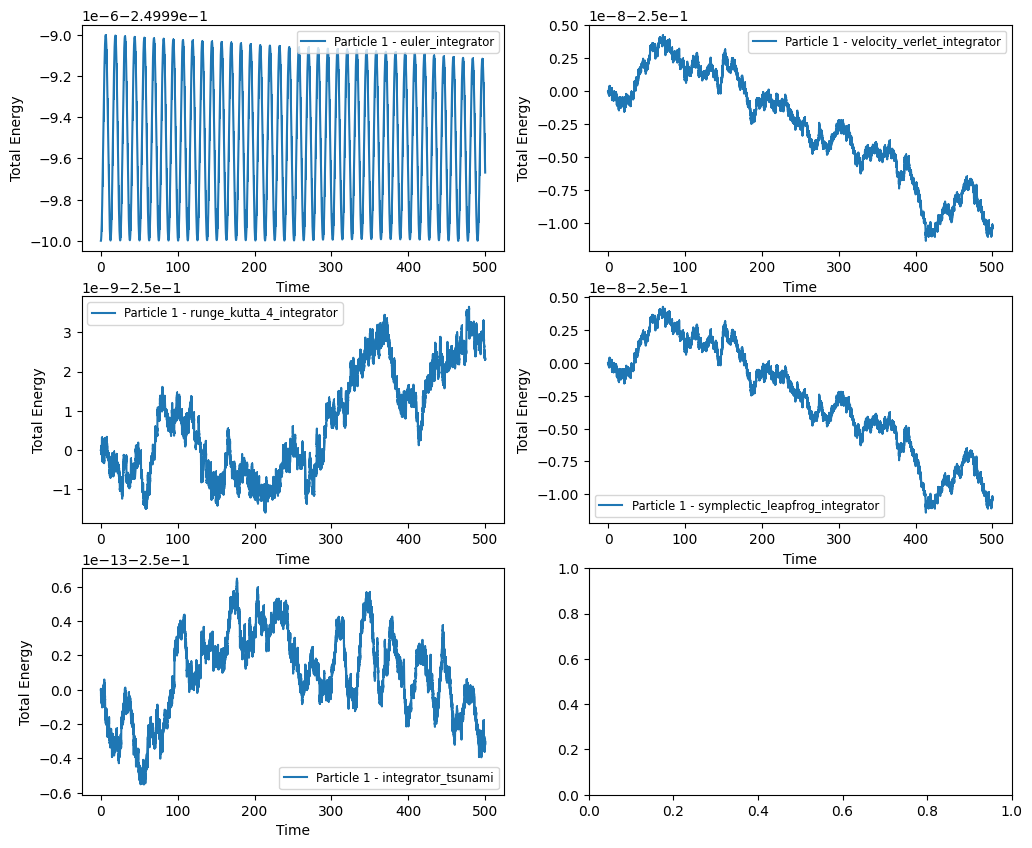

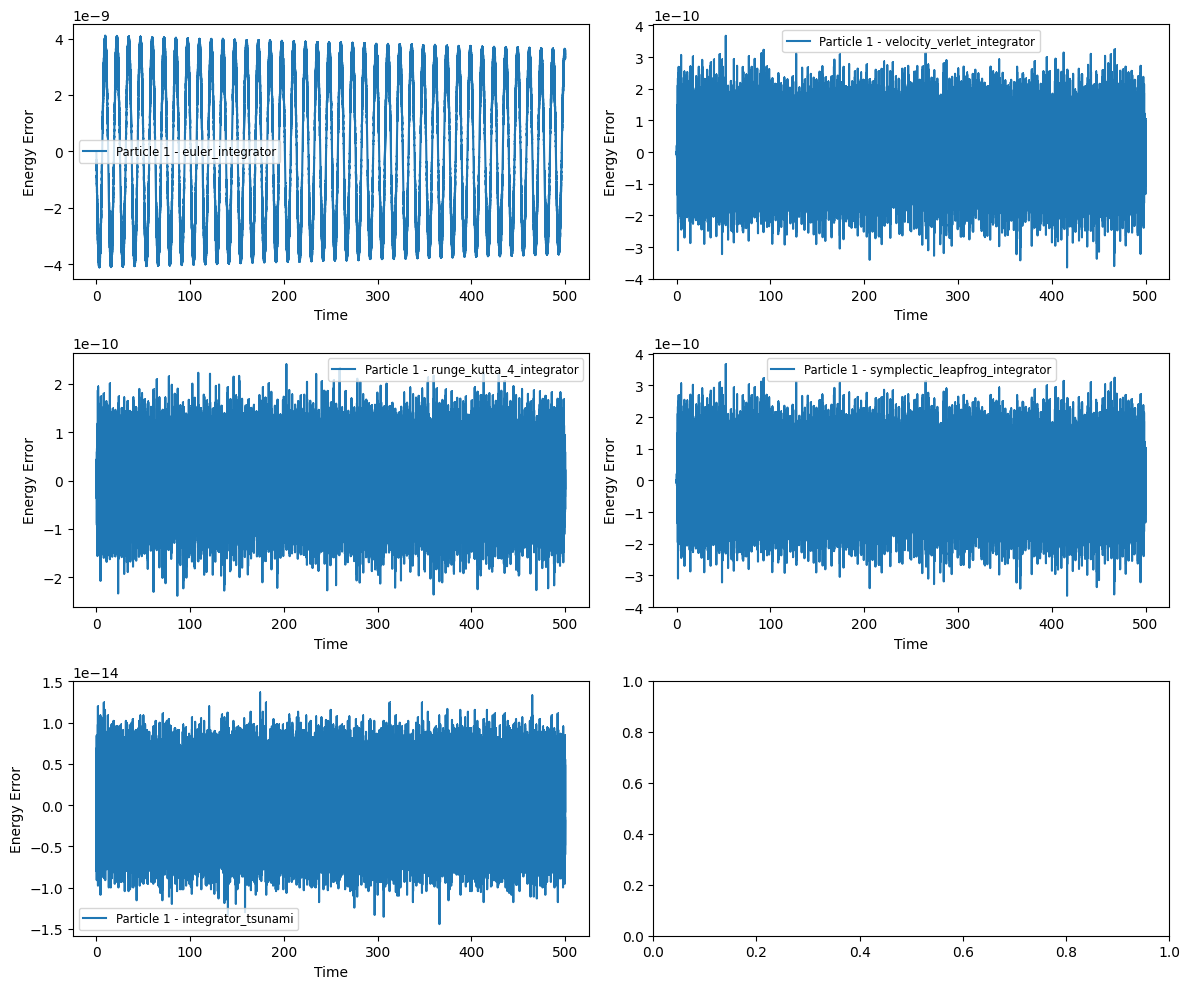

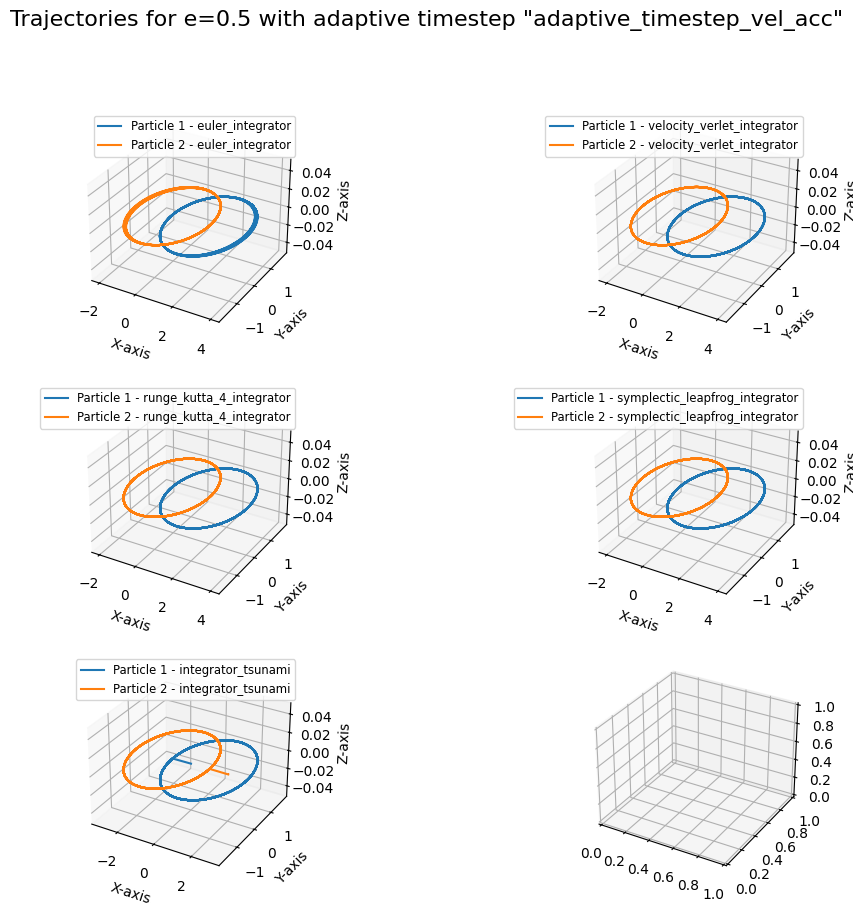

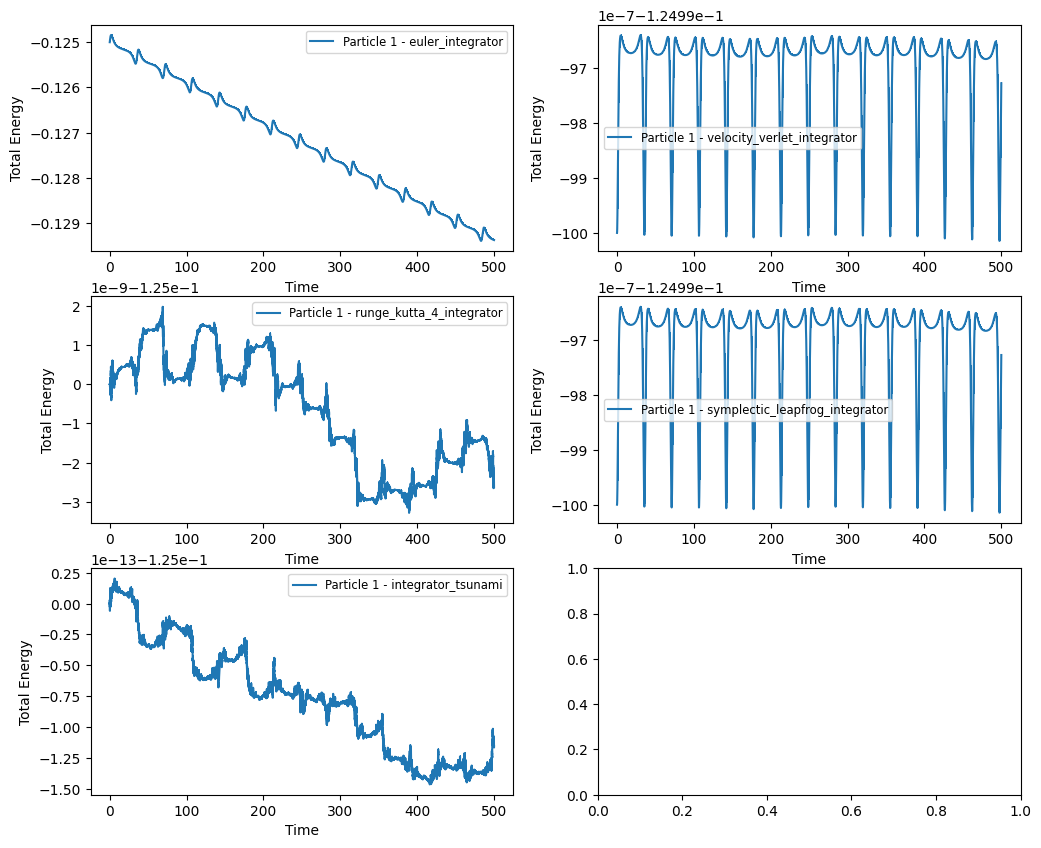

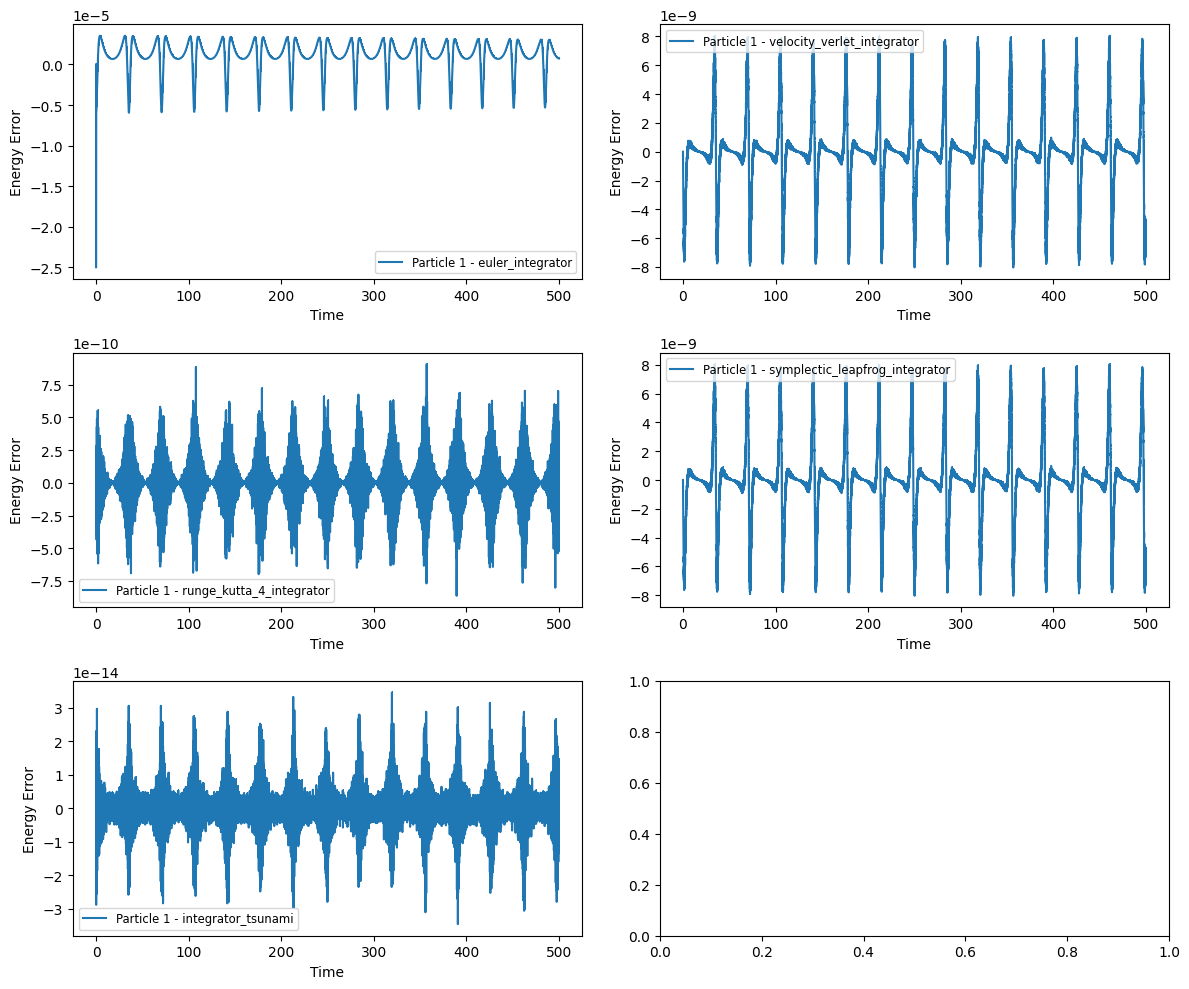

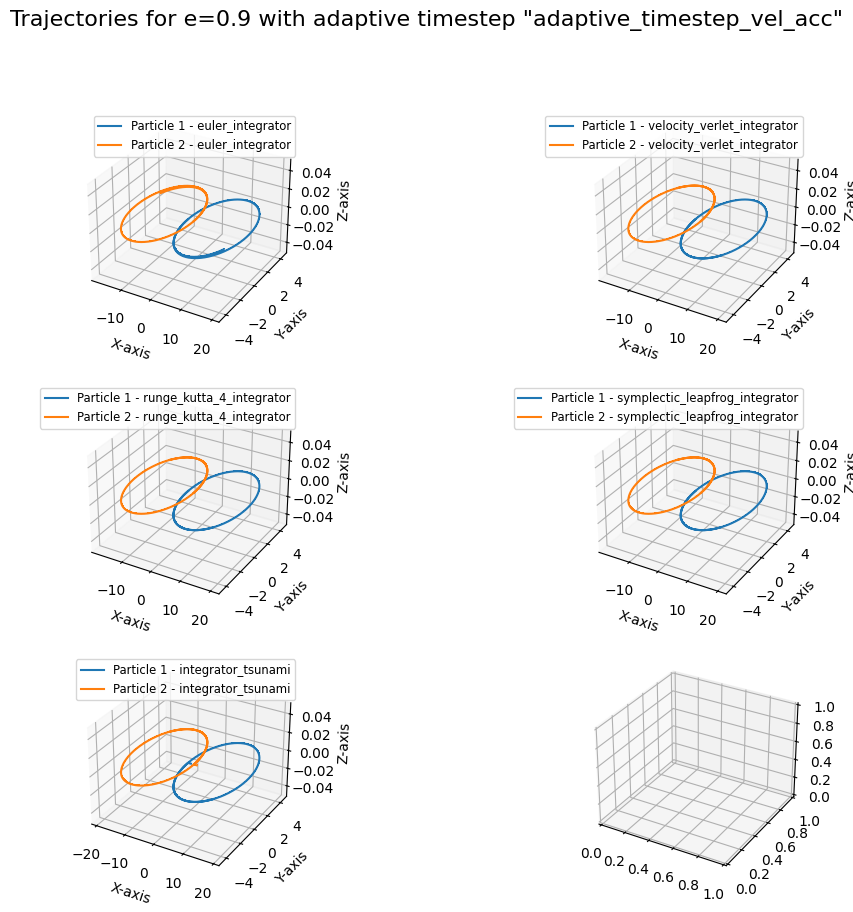

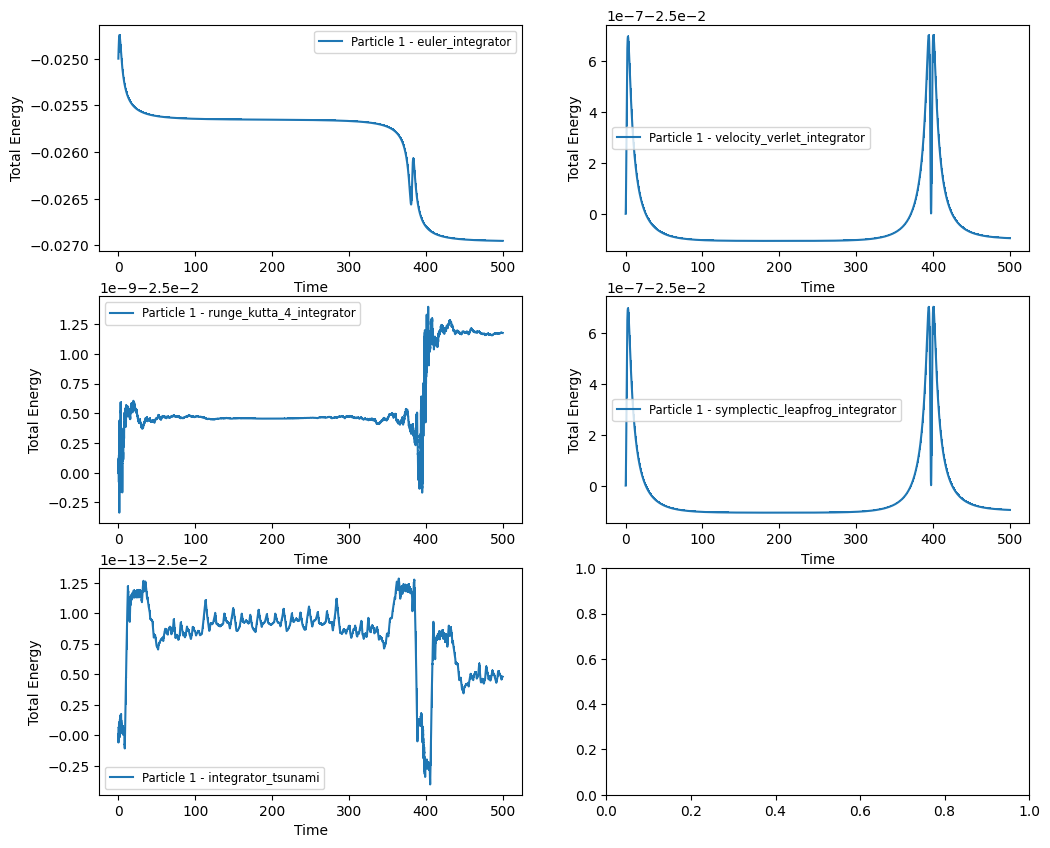

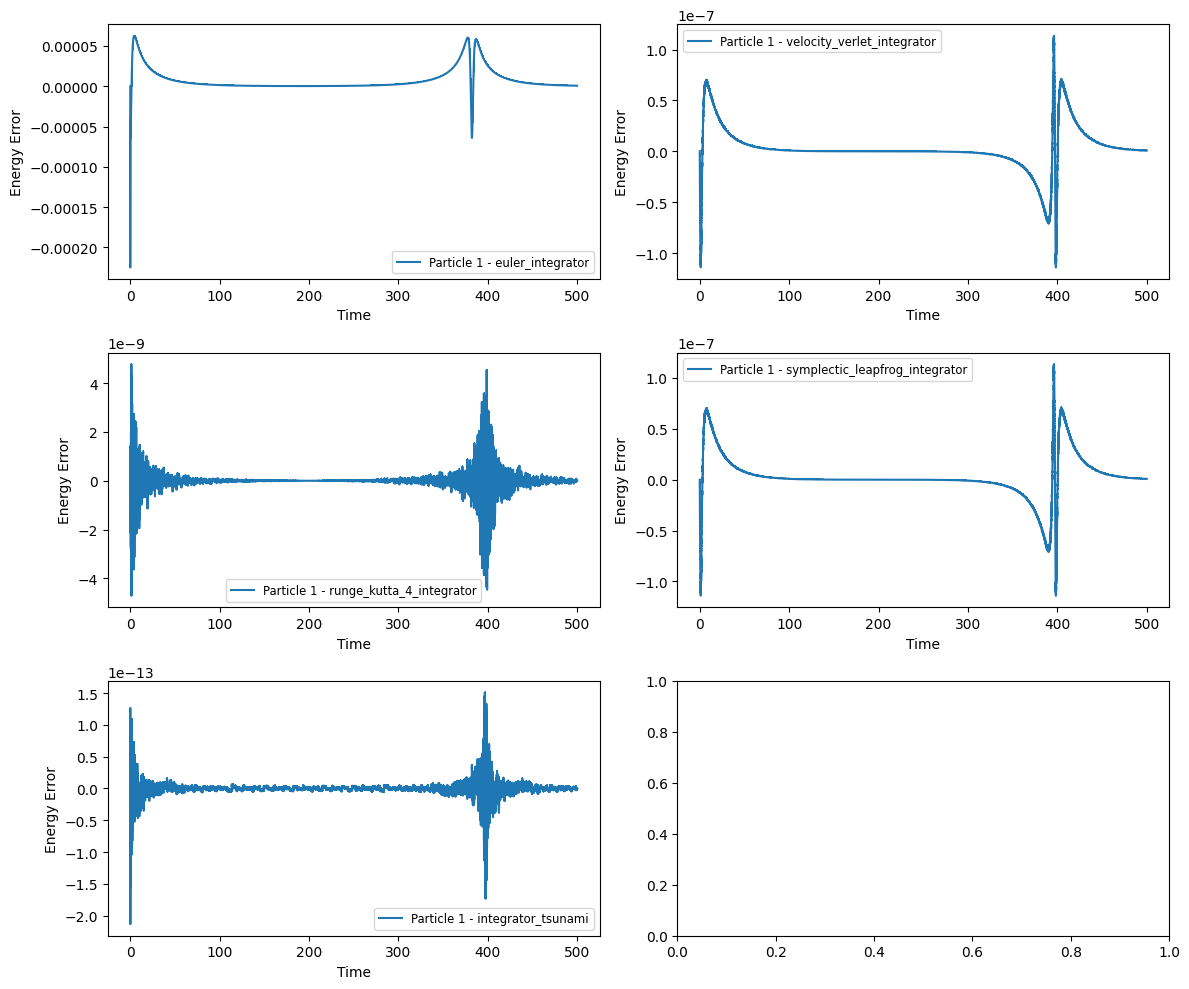

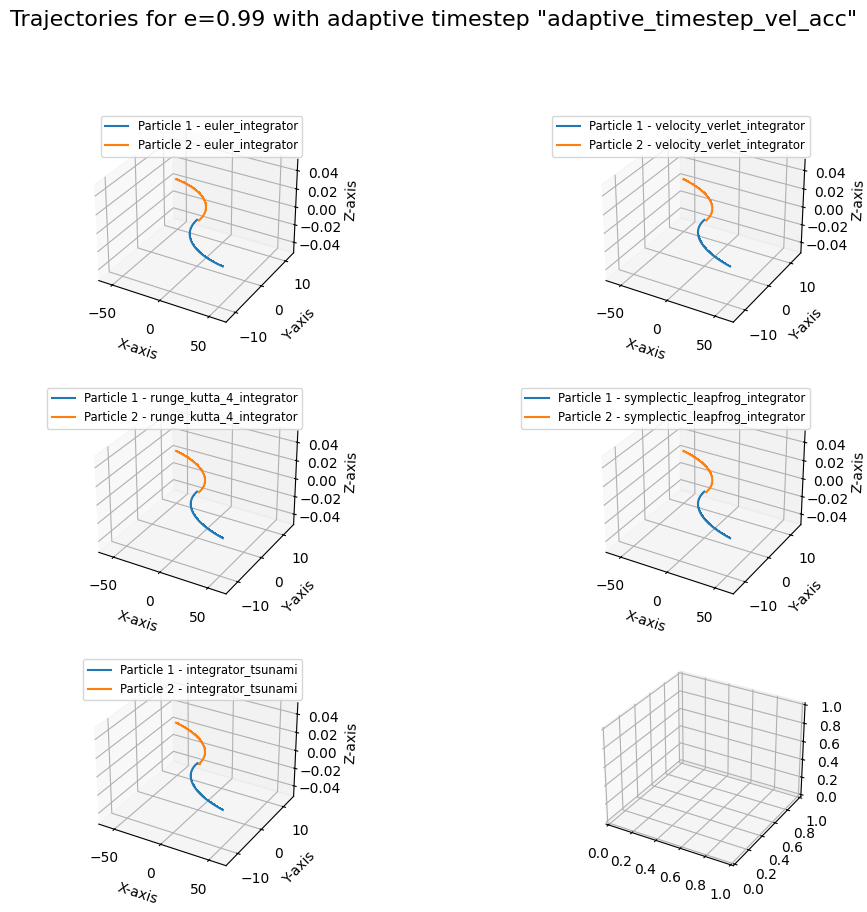

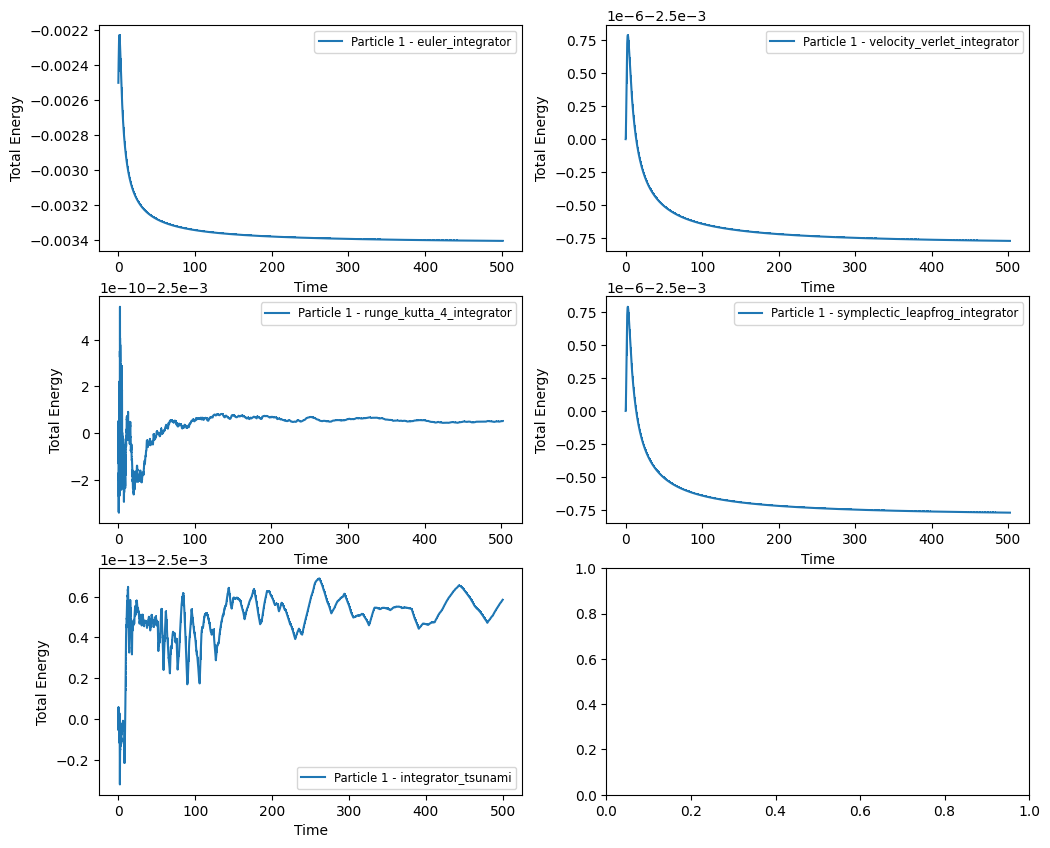

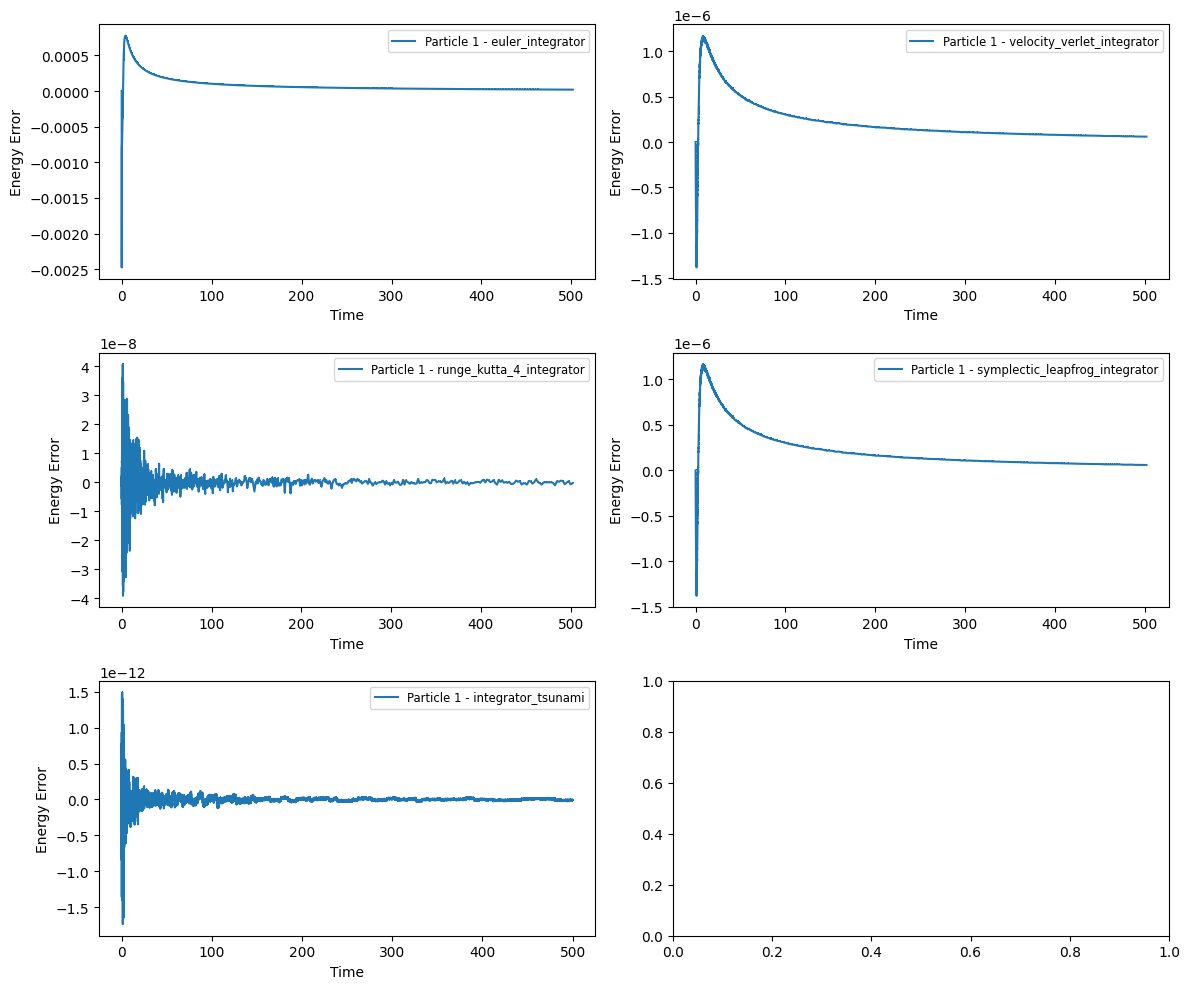

In [19]:
########### Main D with adaptive ###########################################
dt = 0.01
# Different eccentricities
eccentricities = [0,0.5, 0.9, 0.99]
# Different integrators
integrators = [fint.euler_integrator, fint.velocity_verlet_integrator,
               fint.runge_kutta_4_integrator, fint.symplectic_leapfrog_integrator, fint.integrator_tsunami]
adaptive_timestep = ftim.adaptive_timestep_vel_acc


for e in eccentricities:
    
    fig_ad, axes_ad = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), subplot_kw={'projection': '3d'})
    axes_ad = axes_ad.flatten()
    
    fig_tot_energy_ad, axes_tot_energy_ad = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
    axes_tot_energy_ad = axes_tot_energy_ad.flatten()
    
    fig_error_ad,axes_loss_ad = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
    axes_loss_ad = axes_loss_ad.flatten()

    planets = fic.ic_two_body(mass1=1., mass2=1., rp=2., e=e)
    
    for integrator, ax_ad, ax_en_ad,ax_loss_ad in zip(integrators, axes_ad, axes_tot_energy_ad,axes_loss_ad):
        if(integrator.__name__=="integrator_tsunami"):
            #tsunami call
            position, _, _, _, t, tot_en,error = simulate_trajectory_tsunami(fint.integrator_tsunami, planets.copy(), adaptive_timestep)
            plot_trajectory(position, ax_ad, f'{integrator.__name__}')
            plot_energy(tot_en,ax_en_ad, f'{integrator.__name__}')
            plot_energy_loss(error,ax_loss_ad,f'{integrator.__name__}')
        else:
            #other methods
            position, _, _, _, t, tot_en,error = simulate_trajectory(integrator, planets.copy(), adaptive_timestep, fdyn.acceleration_pyfalcon)
            plot_trajectory(position, ax_ad, f'{integrator.__name__}')
            plot_energy(tot_en,ax_en_ad, f'{integrator.__name__}')
            plot_energy_loss(error,ax_loss_ad,f'{integrator.__name__}')
            
    fig_ad.suptitle(f'Trajectories for e={e} with adaptive timestep "{adaptive_timestep.__name__}"', fontsize=16)
    plt.tight_layout()
    plt.show()
    # fig_ad.savefig(f"Trajectories_e_{e}_ad_{adaptive_timestep.__name__}.png")
    # fig_tot_energy_ad.savefig(f"TotalEnergy_e_{e}_ad_{adaptive_timestep.__name__}.png")
    # fig_error_ad.savefig(f"Energy_loss_e_{e}_ad_{adaptive_timestep.__name__}.png")


## Task C and D Comments: Eccentricities \(e = 0, 0.5, 0.9, 0.99\)

1. **Euler Integrator:** Not symplectic nor time-reversible.
2. **Runge-Kutta Integrator:** Not symplectic nor time-reversible.
3. **Velocity Verlet Integrator and Symplectic Leapfrog Integrator:** Equivalent, assuming acceleration is independent of velocity. They are symplectic and time-reversible.
4. **Integrator Tsunami:** Uses regularization and is highly accurate.

### Observations for Eccentricities \(e < 1\)

- Expect elliptical orbits, with \(e = 0\) giving a circular orbit. Total energy for \(e < 1\) is expected to be negative.

Observations:

1. Circular orbit observed for \(e = 0\).
2. Elliptical orbits become more elongated for increasing eccentricities.
3. Total energy is negative for different eccentricities which shows bounded systems in a stable orbit as per theoretical expectations.
4. Total energy changes for different eccentricities. While the total energy is conserved in a conservative system, the distribution between kinetic and potential energy components changes as eccentricity varies. We also see that the negative magnitude of the total energy decreases on increasing the ellipticity.
5. Variation in total energy with time does not agree with the theoretical result where total energy is an integral of motion(due to numerical inaccuracies in the simulation).
6. The amount of variation of energy changes with eccentricity due to the elongation of the orbits and the bodies experiencing different gravitational forces at different points in the orbit.
7. For \(e = 0\), the Euler integrator gives a  periodic change in energy, while other integrators give an erratic change.
8. Velocity Verlet integrator and Symplectic Leapfrog show consistent results.
9. Euler integrator has the highest error, Integrator Tsunami has the lowest error, and Velocity Verlet integrator and Symplectic Leapfrog have the same error.
10. For \(e = 0.5\), all integrators give periodically varying energy errors .
11. For \(e = 0.9\), all integrators give an energy error peak at \(t = 0\) and \(t $\sim$ 400\) .
12. For \(e = 0.99\), Euler integrator, Symplectic Leapfrog integrator, and Velocity Verlet integrator quickly reach a constant value of energy error after a huge change at $t = 0$. Runge-Kutta 4 integrator and Integrator Tsunami give rapidly varying energy errors but converge to a constant value. For highly eccentric or nearly parabolic orbits, the energy error might become constant because the orbit is no longer bound in the traditional sense. The object is effectively on a trajectory to escape the gravitational influence of the other body which we also observe in the trajectory graph, and the specific shape of the orbit becomes less relevant as eccentricity approaches 1.
### Accuracy Comparison for \(e = 0.5, 0.9\), and \(0.99\)

- Euler integrator has low accuracy, Symplectic Leapfrog and Velocity Verlet have moderate accuracy, Runge-Kutta 4 has good accuracy, and Integrator Tsunami has the best accuracy.

13. For \(e = 0.5, 0.9\), Euler integrator gives a change in energy of order \($10^{-3}$\), Symplectic Leapfrog and Velocity Verlet give a change in energy of the order \($10^{-6}$\), Runge-Kutta 4 gives \($10^{-9}$\), and Integrator Tsunami gives \($10^{-13}$\).

14. For \(e = 0.99\), Euler integrator, Symplectic Leapfrog, and Velocity Verlet give a change in energy of the order \($10^{-3}$\), Runge-Kutta 4 gives \($10^{-9}$\), and Integrator Tsunami gives \($10^{-13}$\). Symplectic Leapfrog and Velocity Verlet become inaccurate for very high eccentricities, while Runge-Kutta 4 maintains accuracy, and Integrator Tsunami is the most accurate.
So we observe that the second-order methods i.e. Symplectic Leapfrog and Velocity Verlet start losing accuracy as we increase the ellipticity. However, for higher orders like the Runge Kutta and the Tsunami which uses regularization, this doesn't have any effect.

### Trajectories for \(e = 0.5, 0.9, 0.99\)


15. Trajectories for \(e = 0.5\), \(e = 0.9\), and \(e = 0.99\)  show deviations for the Euler integrator, while other integrators match theoretical trajectories.
Trajectories for the Euler integrator deviate from theoretical expectations as the Euler method uses a simple forward difference approximation to update the position and velocity of particles in each time step. However, it does not account for higher-order terms when performing the  Taylor series expansion which leads to a cumulative error over multiple time steps. This causes the trajectory to deviate from the true solution over time.


[Link to Git Repo branch for assignmnet 3](https://gitlab.com/ca23_unipd/pod_compastro23/-/tree/assignment3_integrators/Fireworks/fireworks?ref_type=heads)